In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import copy
import random
import itertools
import tqdm

import time
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms

from IPython.display import display, clear_output
from sklearn.decomposition import PCA

In [2]:
class Autoencoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Encoder
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 64),
            nn.ReLU(True),
            nn.Linear(64, encoded_space_dim)
        )
        
        ### Decoder
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 3 * 3 * 32),
            nn.ReLU(True)
        )
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def encode(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = x.view([x.size(0), -1])
        # Apply linear layers
        x = self.encoder_lin(x)
        return x
    
    def decode(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Reshape
        x = x.view([-1, 32, 3, 3])
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [3]:
testset = np.load('testset.npy', allow_pickle=True)
tvet_list = np.load('tvet_list.npy', allow_pickle=True)

In [4]:
encode_dim_list = [2,6,8,10,15,20, 30, 50, 70]
net_list = []

for encode_dim in encode_dim_list:
    net = Autoencoder(encoded_space_dim=encode_dim)
    loss_fn = torch.nn.MSELoss()
    
    name = 'nets/conv_autoencoder_' + str(encode_dim) +'.torch'
    
    net.load_state_dict(torch.load(name, map_location='cpu'))
    net_list.append(copy.deepcopy(net))
    
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Selected device:', device)

Selected device: cuda


In [5]:
test_loss_list = tvet_list[3::4]
len(test_loss_list)

9

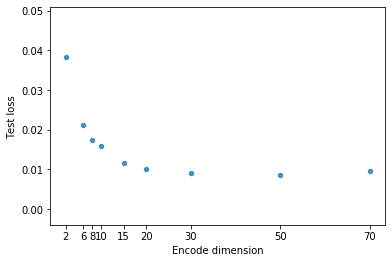

In [6]:
fig, ax = plt.subplots()
plt.scatter(encode_dim_list, test_loss_list, alpha = 0.8, s = 19)
ax.set_xticks([2,6,8,10,15,20, 30, 50, 70])
plt.xlabel('Encode dimension')
plt.ylabel('Test loss')
plt.savefig('test_loss.pdf', dpi = 300)
plt.show()

In [7]:
def add_noise(img, sigma):
    noise = sigma * np.random.randn(*img.shape)
    img = np.clip(img + noise, 0., 1.)            
    return img


def noise_test(net, testset, sigma, device, rep = 1):
    avg_loss = 0
    net.to(device)
    for i in range(rep):
        for img, lab in testset:
            noised_img = add_noise(img, sigma)
            
            #plt.imshow(img.reshape((28,28)))
            #plt.show()
            #plt.imshow(noised_img.reshape((28,28)))
            #plt.show()
            
            noised_img = torch.tensor(noised_img.reshape(28,28))
            noised_img = noised_img[None, None, :, :].to(device).float()
            
            img = torch.tensor(img.reshape(28,28))
            img = img[None, None, :, :].to(device).float()
            
            net.eval()
            with torch.no_grad():
                rec_img  = net(noised_img)
                
            #plt.imshow(rec_img.cpu().view(28,28))
            #plt.show()

            loss_fn = torch.nn.MSELoss()
            #print(loss_fn(rec_img, img))
            
            avg_loss += loss_fn(rec_img, img)
    
    return avg_loss/(len(testset)*rep)

In [9]:
loss_noise_log = []
sigma_list = np.linspace(0.05,1,10)

perform = True

if perform:
    for net, edim, test_loss in zip(net_list, encode_dim_list, test_loss_list):
        for sigma in sigma_list:
            print('Encode dimension ' + str(edim) + ', sigma', str(sigma))
            terr = noise_test(net, testset, sigma, device)

            print('Test error', terr.data.cpu().numpy())
            loss_noise_log.append(copy.deepcopy(float(terr)))
        print('\n')

Encode dimension 2, sigma 0.05
Test error 0.038277075
Encode dimension 2, sigma 0.15555555555555556
Test error 0.03829403
Encode dimension 2, sigma 0.2611111111111111
Test error 0.038438242
Encode dimension 2, sigma 0.36666666666666664
Test error 0.03868713
Encode dimension 2, sigma 0.4722222222222222
Test error 0.03921907
Encode dimension 2, sigma 0.5777777777777778
Test error 0.040646505
Encode dimension 2, sigma 0.6833333333333333
Test error 0.04263911
Encode dimension 2, sigma 0.788888888888889
Test error 0.045754917
Encode dimension 2, sigma 0.8944444444444445
Test error 0.04977795
Encode dimension 2, sigma 1.0
Test error 0.053777173


Encode dimension 6, sigma 0.05
Test error 0.021164287
Encode dimension 6, sigma 0.15555555555555556
Test error 0.021269063
Encode dimension 6, sigma 0.2611111111111111
Test error 0.02161301
Encode dimension 6, sigma 0.36666666666666664
Test error 0.022189494
Encode dimension 6, sigma 0.4722222222222222
Test error 0.023167798
Encode dimension 6, sigm

In [19]:
np.save('loss_noise.npy', loss_noise_log, allow_pickle=True)
#loss_noise_log = np.load('loss_noise.npy', allow_pickle=True)

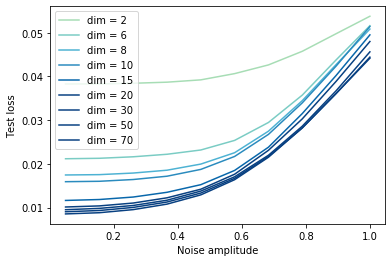

In [18]:
count = 3
cmap = plt.cm.GnBu
sigma_list = np.linspace(0.05,1,10)

for edim, terr, tloss in zip(encode_dim_list, np.array(loss_noise_log).reshape((9,10)),test_loss_list):
    plt.plot(sigma_list, terr, label = 'dim = %i' % edim, color=cmap(count / float(8)))
    count += 1
plt.xlabel('Noise amplitude')
plt.ylabel('Test loss')
plt.legend()
plt.savefig('loss_sigma_dae.pdf', dpi = 300)
plt.show()

In [22]:
def plot_rec(net, original_img, noised_img, filename):
    net.eval()
    with torch.no_grad():
        rec_img  = net(noised_img)
        
    fig, axs = plt.subplots(1, 3, figsize=(12,6))
    
    axs[0].imshow(original_img.cpu().squeeze().numpy(), cmap='gray_r')
    axs[0].set_title('Original image')
    axs[1].imshow(noised_img.cpu().squeeze().numpy(), cmap='gray_r')
    axs[1].set_title('Noised image')
    axs[2].imshow(rec_img.cpu().squeeze().numpy(), cmap='gray_r')
    axs[2].set_title('Reconstructed image')
    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')

    plt.tight_layout()
    plt.pause(0.1)
    fig.savefig(filename, dpi = 300)
    plt.show()

In [41]:
idx = 381
img = testset[idx][0]
noised_img = add_noise(img, 0.5)

img = torch.tensor(img.reshape(28,28))
img = img[None, None, :, :].to(device)

noised_img = torch.tensor(noised_img.reshape(28,28))
noised_img = noised_img[None, None, :, :].to(device)

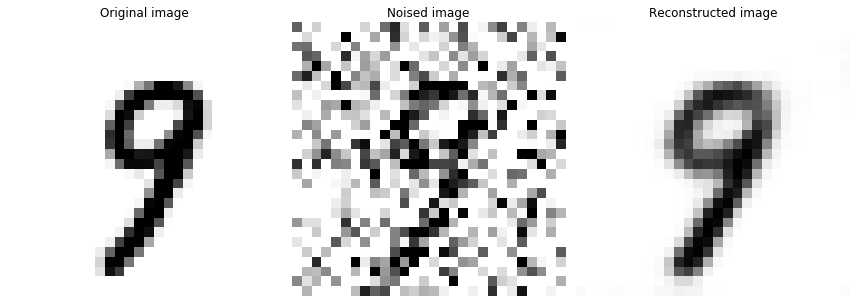

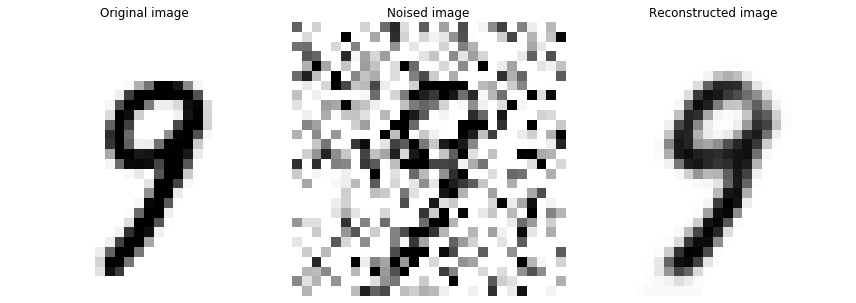

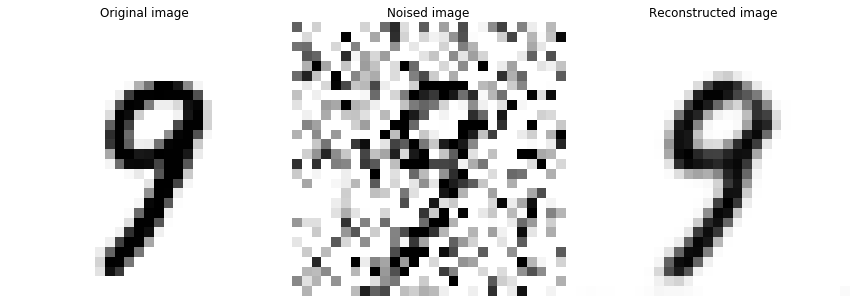

In [43]:
for i, de in zip([1,4,6], [6,15,30]):
    net = net_list[i]
    net.to(device)
    plot_rec(net, img.float(), noised_img.float(), 'rec_dae' + str(de) +'_noise.pdf')
    plt.show()

In [13]:
def corruption_test(net, testset, n_corr, device):
    avg_loss = 0
    net.to(device)
    
    for img, lab in testset:
        img_corrupted = copy.deepcopy(img.reshape(28,28))
        
        for i in range(n_corr):
            idxs = np.random.randint(0,28, size = 2)
            if img_corrupted[idxs[0],idxs[1]] == 0:
                img_corrupted[idxs[0],idxs[1]] = 1
            else:
                img_corrupted[idxs[0],idxs[1]] = 0
        
        img = torch.tensor(img.reshape(28,28))
        img = img[None, None, :, :].to(device)

        img_corrupted = torch.tensor(img_corrupted)
        img_corrupted = img_corrupted.cuda()[None, None, :, :]
        
        net.eval()
        with torch.no_grad():
            rec_img  = net(img_corrupted)
            
        loss_fn = torch.nn.MSELoss()
        avg_loss += loss_fn(rec_img, img)
    
    return avg_loss/len(testset)

In [15]:
loss_corr_log = []
ncorr_list = np.arange(10,101,10)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Selected device:', device)

perform = True

if perform:
    for net, edim, test_loss in zip(net_list, encode_dim_list, test_loss_list):
        for ncorr in ncorr_list:
            print('Encode dimension ' + str(edim) + ', corrupting', str(ncorr))
            temp = corruption_test(net, testset, ncorr, device)

            temp = (temp - test_loss)/test_loss*100
            temp = temp.cpu().numpy()
            print('Error increase', temp)

            loss_corr_log.append(copy.deepcopy(float(temp)))
        print('\n')

Selected device: cuda
Encode dimension 2, corrupting 10
Error increase 0.057091065
Encode dimension 2, corrupting 20
Error increase 0.15210344
Encode dimension 2, corrupting 30
Error increase 0.3040999
Encode dimension 2, corrupting 40
Error increase 0.4368974
Encode dimension 2, corrupting 50
Error increase 0.6646684
Encode dimension 2, corrupting 60
Error increase 0.95180625
Encode dimension 2, corrupting 70
Error increase 1.132854
Encode dimension 2, corrupting 80
Error increase 1.4329468
Encode dimension 2, corrupting 90
Error increase 1.7409954
Encode dimension 2, corrupting 100
Error increase 2.0591395


Encode dimension 6, corrupting 10
Error increase 0.20871128
Encode dimension 6, corrupting 20
Error increase 0.46983138
Encode dimension 6, corrupting 30
Error increase 0.8728822
Encode dimension 6, corrupting 40
Error increase 1.2649409
Encode dimension 6, corrupting 50
Error increase 1.7044975
Encode dimension 6, corrupting 60
Error increase 2.3959334
Encode dimension 6, corrup

In [ ]:
np.save('loss_corr.npy', loss_corr_log, allow_pickle=True)
loss_corr_log = np.load('loss_corr.npy', allow_pickle=True)

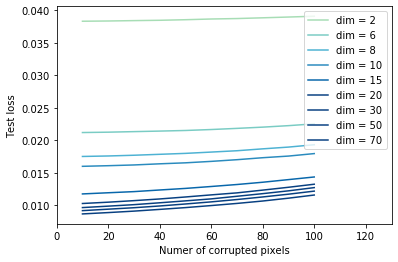

In [24]:
count = 3
cmap = plt.cm.GnBu
for edim, errinc, tloss in zip(encode_dim_list, np.array(loss_corr_log).reshape((9,10)),test_loss_list):
    errinc = (1+errinc/100)*tloss.cpu().numpy()
    plt.plot(ncorr_list, errinc, label = 'dim = %i' % edim, color=cmap(count / float(8)))
    count += 1
plt.xlabel('Numer of corrupted pixels')
plt.ylabel('Test loss')
plt.xlim(0,130)
plt.legend()
plt.savefig('loss_corr_dae.pdf', dpi = 300)
plt.show()

In [57]:
idx = 381
img = testset[idx][0]

img_corrupted = copy.deepcopy(img.reshape(28,28))
        
for i in range(200):
    idxs = np.random.randint(0,28, size = 2)
    if img_corrupted[idxs[0],idxs[1]] == 0:
        img_corrupted[idxs[0],idxs[1]] = 1
    else:
        img_corrupted[idxs[0],idxs[1]] = 0

img = torch.tensor(img.reshape(28,28))
img = img[None, None, :, :].to(device)

img_corrupted = torch.tensor(img_corrupted)
img_corrupted = img_corrupted[None, None, :, :].to(device)

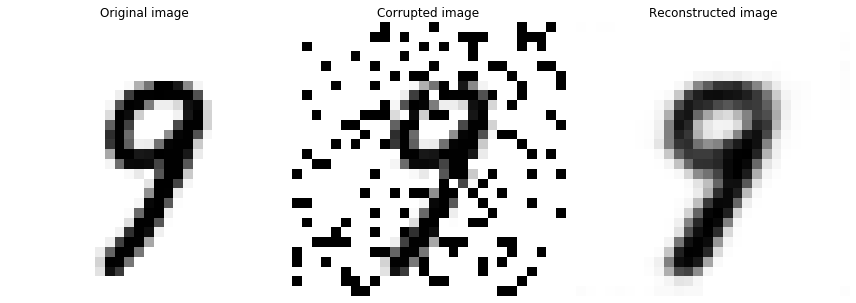

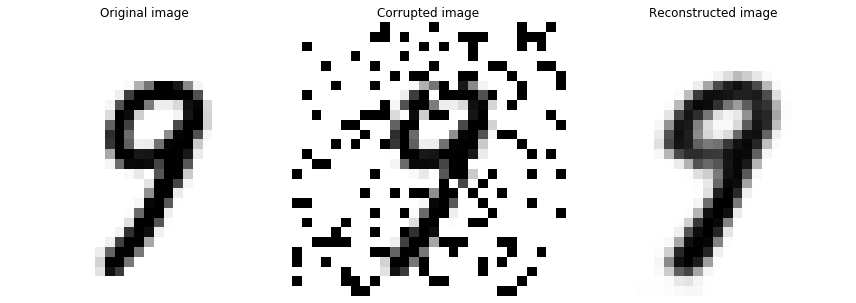

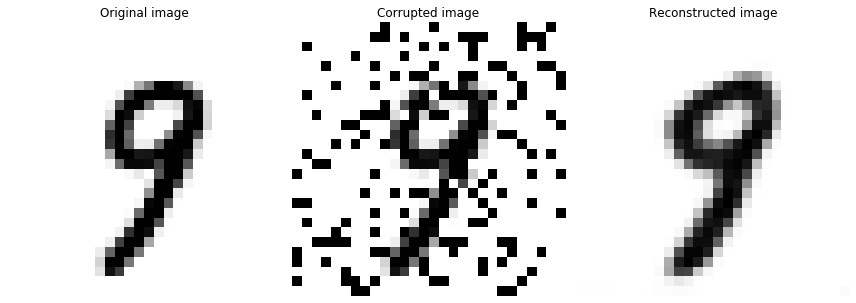

In [59]:
def plot_rec(net, original_img, noised_img, filename):
    net.eval()
    with torch.no_grad():
        rec_img  = net(noised_img)
        
    fig, axs = plt.subplots(1, 3, figsize=(12,6))
    
    axs[0].imshow(original_img.cpu().squeeze().numpy(), cmap='gray_r')
    axs[0].set_title('Original image')
    axs[1].imshow(noised_img.cpu().squeeze().numpy(), cmap='gray_r')
    axs[1].set_title('Corrupted image')
    axs[2].imshow(rec_img.cpu().squeeze().numpy(), cmap='gray_r')
    axs[2].set_title('Reconstructed image')
    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')

    plt.tight_layout()
    plt.pause(0.1)
    fig.savefig(filename, dpi = 300)
    plt.show()


for i, de in zip([1,4,6], [6,15,30]):
    net = net_list[i]
    net.to(device)
    plot_rec(net, img.float(), img_corrupted.float(), 'rec_dae' + str(de) +'_corr.pdf')
    plt.show()

In [25]:
def encode_images(net, testset, device):
    ### Get the encoded representation of the test samples
    encoded_samples = []
    for sample in testset:
        img = sample[0].reshape((28,28))
        label = sample[1]
        # Encode image
        img = torch.tensor(img)[None, None, :, :].to(device)
        net.eval()
        with torch.no_grad():
            encoded_img  = net.encode(img)
        # Append to list
        encoded_samples.append((list(encoded_img.cpu().flatten().numpy()), label))
    
    return encoded_samples

In [37]:
net30.to(device)

encoded_samples = encode_images(net30, testset, device)
hidden_states = list(np.array(encoded_samples)[:,0])
labels = list(np.array(encoded_samples)[:,1])

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(hidden_states)

In [35]:
### Visualize encoded space
color_map = {
        0: '#ab2e2e',
        1: '#d68711',
        2: '#d6b211',
        3: '#ccd611',
        4: '#91d611',
        5: '#44a617',
        6: '#17a676',
        7: '#17a4a6',
        8: '#249bc9',
        9: '#2463c9'
        }

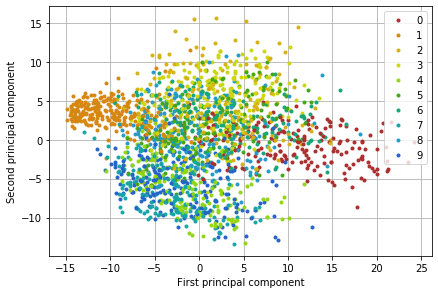

In [39]:
npoints = 2000

for enc_sample, label in zip(principalComponents[0:npoints], labels[0:npoints]):
    plt.plot(enc_sample[0], enc_sample[1], marker='.', color=color_map[label])
plt.grid(True)
plt.legend([plt.Line2D([0], [0], ls='', marker='.', color=c, label=l) for l, c in color_map.items()],
           color_map.keys())
plt.tight_layout()
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.savefig('pca_dae.pdf', dpi = 100)
plt.show()